In [25]:
# ---------- imports ----------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [26]:
# ---------- load & normalize column names ----------
df = pd.read_csv("RELIANCE.NS.csv")
df.columns = df.columns.str.strip().str.lower()   # makes camelCase -> lower case (e.g. adjclose -> adjclose)

# ensure expected columns exist
# expected (case-insensitive): date, high, low, close, adjclose, volume
print("columns:", df.columns.tolist())

columns: ['date', 'open', 'high', 'low', 'close', 'adj close', 'volume']


In [27]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.sort_index(inplace=True)

# ---------- create return & target ----------
df['return'] = df['close'].pct_change()
# target: 1 if next day return > 0 else 0
df['target'] = (df['return'].shift(-1) > 0).astype(int)


In [28]:
# ---------- feature engineering ----------
df['ma5']  = df['close'].rolling(5).mean()
df['ma10'] = df['close'].rolling(10).mean()
df['ma20'] = df['close'].rolling(20).mean()

df['volatility'] = df['return'].rolling(10).std()
df['range'] = df['high'] - df['low']
df['close_high_ratio'] = df['close'] / df['high']

# drop rows with NaNs produced by pct_change/rolling/shift
df.dropna(inplace=True)

# ---------- features & target ----------
features = [
    'close', 'high', 'low', 'volume',
    'ma5', 'ma10', 'ma20',
    'volatility', 'range', 'close_high_ratio'
]

X = df[features].copy()
y = df['target'].copy()

In [29]:
# Use last 20% of data as test set (simulates future)
split_index = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

print("Train size:", X_train.shape, "Test size:", X_test.shape)

# ---------- scaling ----------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

Train size: (4020, 10) Test size: (1006, 10)


In [30]:
# ---------- Model 1: Logistic Regression ----------
lr = LogisticRegression(max_iter=500)
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
y_proba_lr = lr.predict_proba(X_test_scaled)[:,1]

print("\n=== Logistic Regression ===")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("ROC AUC:", roc_auc_score(y_test, y_proba_lr))
print(confusion_matrix(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))


=== Logistic Regression ===
Accuracy: 0.49204771371769385
ROC AUC: 0.5040588011899487
[[444  44]
 [467  51]]
              precision    recall  f1-score   support

           0       0.49      0.91      0.63       488
           1       0.54      0.10      0.17       518

    accuracy                           0.49      1006
   macro avg       0.51      0.50      0.40      1006
weighted avg       0.51      0.49      0.39      1006



In [31]:
# ---------- Model 2: Random Forest (no scaling required) ----------
rf = RandomForestClassifier(n_estimators=300, max_depth=6, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:,1]

print("\n=== Random Forest ===")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, y_proba_rf))
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))



=== Random Forest ===
Accuracy: 0.4821073558648111
ROC AUC: 0.5182922969808216
[[472  16]
 [505  13]]
              precision    recall  f1-score   support

           0       0.48      0.97      0.64       488
           1       0.45      0.03      0.05       518

    accuracy                           0.48      1006
   macro avg       0.47      0.50      0.35      1006
weighted avg       0.47      0.48      0.34      1006



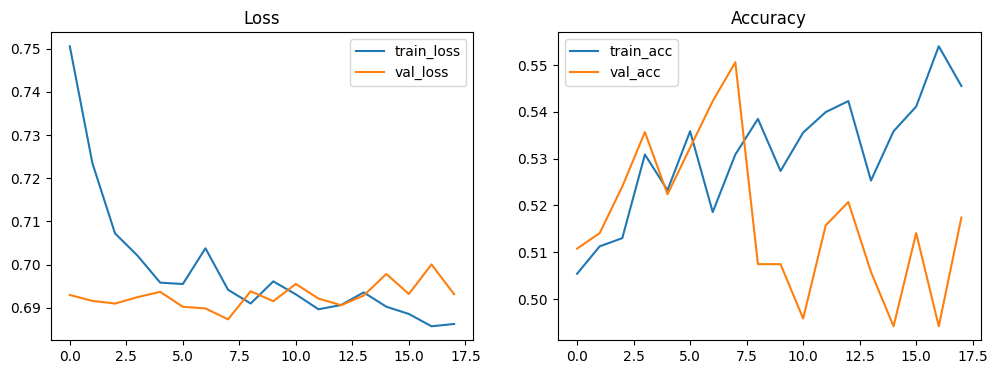

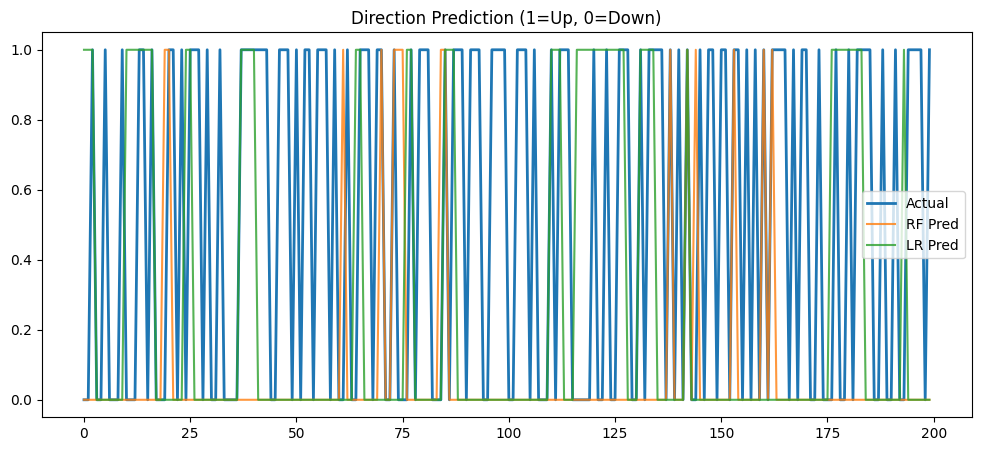

In [33]:
# ---------- Plot training curves ----------
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title("Accuracy")
plt.legend()
plt.show()

# ---------- Visual compare predictions (first 200 points) ----------
n_plot = min(200, len(y_test))
plt.figure(figsize=(12,5))
plt.plot(y_test.values[:n_plot], label='Actual', linewidth=2)
plt.plot(y_pred_rf[:n_plot], label='RF Pred', alpha=0.8)
plt.plot(y_pred_lr[:n_plot], label='LR Pred', alpha=0.8)
plt.legend()
plt.title('Direction Prediction (1=Up, 0=Down)')
plt.show()